## Preamble

### Project Template

In [1]:
%load_ext autoreload

In [2]:
import os as _os

_os.chdir(_os.environ["PROJECT_ROOT"])
_os.path.realpath(_os.path.curdir)

'/pollard/data/projects/bsmith/strain-corr'

### Imports

In [3]:
import os
import subprocess
import sys
import time
from datetime import datetime
from glob import glob
from itertools import chain, product
from tempfile import mkstemp

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import sfacts as sf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

import lib.plot
from lib.dissimilarity import load_dmat_as_pickle
from lib.pandas_util import align_indexes, aligned_index, idxwhere, invert_mapping

/pollard/home/bsmith/.snakemake/conda/8dd43b17b83f3accb639079fe0075b14_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import lib.thisproject.data

### Set Style

In [5]:
sns.set_context("paper")
plt.rcParams["figure.dpi"] = 200

## Data Setup

### Metadata

In [6]:
species_list = (
    pd.read_table("meta/species_group.tsv")[lambda x: x.species_group_id == "hmp2"]
    .species_id.astype(str)
    .unique()
)

In [7]:
def parse_taxonomy_string(taxonomy_string):
    values = taxonomy_string.split(";")
    return pd.Series(values, index=["d__", "p__", "c__", "o__", "f__", "g__", "s__"])

In [8]:
species_taxonomy_inpath = "ref/uhgg_genomes_all_v2.tsv"

species_taxonomy = (
    pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]
    .assign(species_id=lambda x: "1" + x.MGnify_accession.str.split("-").str[2])
    .set_index("species_id")
    .Lineage.apply(parse_taxonomy_string)
)
species_taxonomy

/tmp/bsmith/ipykernel_4131383/4268967817.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_table(species_taxonomy_inpath)[lambda x: x.Genome == x.Species_rep]


,d__,p__,c__,o__,f__,g__,s__
species_id,,,,,,,
100001,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__GCA-900066495,s__
100002,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Blautia_A,s__Blautia_A sp900066165
100003,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Rikenellaceae,g__Alistipes,s__Alistipes shahii
100004,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Anaerotruncus,s__Anaerotruncus colihominis
100005,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Peptostreptococcales,f__Peptostreptococcaceae,g__Terrisporobacter,s__Terrisporobacter glycolicus_A
...,...,...,...,...,...,...,...
104640,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Prevotella,s__
104641,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Burkholderiales,f__Burkholderiaceae,g__Sutterella,s__
104642,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__,g__,s__


In [9]:
phylum_palette = lib.plot.construct_ordered_palette(
    sorted(species_taxonomy.p__.unique()),
    cm="tab10",
)

# assert len(set(phylum_palette.values())) == len((phylum_palette.values()))

In [10]:
mgen = pd.read_table("meta/hmp2/mgen.tsv", index_col="library_id")
preparation = pd.read_table("meta/hmp2/preparation.tsv", index_col="preparation_id")
stool = pd.read_table("meta/hmp2/stool.tsv", index_col="stool_id")
visit = pd.read_table("meta/hmp2/visit.tsv", index_col="visit_id")
subject = pd.read_table("meta/hmp2/subject.tsv", index_col="subject_id")

meta_all = (
    mgen.join(preparation.drop(columns="library_type"), on="preparation_id")
    .join(stool, on="stool_id")
    .join(visit, on="visit_id", rsuffix="_")
    .join(subject, on="subject_id")
    .assign(
        new_name=lambda x: (
            x[["subject_id", "week_number"]]
            .assign(library_id=x.index)
            .assign(week_number=lambda x: x.week_number.fillna(999).astype(int))
            .apply(lambda x: "_".join(x.astype(str)), axis=1)
        )
    )
    # .reset_index()
    # .set_index('new_name')
)

library_id_to_new_name = meta_all.new_name

assert not any(meta_all.subject_id.isna())

# TODO: Rename samples based on subject and visit number
# TODO: Drop duplicate stools

### Species Depth

In [11]:
species_depth = []
_missing_species = []

for species in tqdm(species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gene99_v20-v23-agg75.spgc_specgene-ref-filt-p95.species_depth.tsv"
    if not os.path.exists(inpath):
        _missing_species.append(species)
        continue
    data = pd.read_table(inpath, names=["sample", "depth"]).assign(species=species)
    species_depth.append(data)
species_depth = (
    pd.concat(species_depth)
    .set_index(["sample", "species"])
    .depth.unstack(fill_value=0)
)

print(
    len(_missing_species),
    "out of",
    len(species_list),
    "species are missing.",
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:01<00:00, 528.59it/s]


0 out of 627 species are missing.


In [12]:
depth_thresh = 0.2

species_found = species_depth > depth_thresh
species_prevalence = (
    species_found.groupby(meta_all.subject_id).any().mean().sort_values(ascending=False)
)

species_rabund_when_found = species_depth.divide(species_depth.sum(1), axis=0).where(
    species_found, np.nan
)
species_mean_rabund_when_found = (
    species_rabund_when_found.groupby(meta_all.subject_id)
    .mean()
    .mean()
    .sort_values(ascending=False)
)
species_median_rabund_when_found = (
    species_rabund_when_found.groupby(meta_all.subject_id)
    .median()
    .median()
    .sort_values(ascending=False)
)

species_prevalence.to_frame("prevalence").assign(
    mean_rabund=species_mean_rabund_when_found,
    median_rabund=species_median_rabund_when_found,
).join(species_taxonomy).head(20)

,prevalence,mean_rabund,median_rabund,d__,p__,c__,o__,f__,g__,s__
species,,,,,,,,,,
101345,0.971698,0.015968,0.007896,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides xylanisolvens
101378,0.962264,0.027595,0.012972,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides ovatus
102478,0.962264,0.162656,0.137527,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides_B,s__Bacteroides_B dorei
101300,0.943396,0.020052,0.010758,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,s__Faecalibacterium prausnitzii_K
102545,0.943396,0.023713,0.008445,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Oscillospirales,f__Ruminococcaceae,g__Faecalibacterium,s__Faecalibacterium prausnitzii_G
102492,0.933962,0.043301,0.022242,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Agathobacter,s__Agathobacter rectalis
102528,0.933962,0.006703,0.003563,d__Bacteria,p__Firmicutes_A,c__Clostridia,o__Lachnospirales,f__Lachnospiraceae,g__Anaerostipes,s__Anaerostipes hadrus
102549,0.933962,0.011088,0.006721,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides caccae
100196,0.933962,0.012013,0.004226,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Bacteroidales,f__Bacteroidaceae,g__Bacteroides,s__Bacteroides thetaiotaomicron


### Strain Statistics

In [13]:
def classify_genome(x):
    if (x.genome_type == "Isolate") & x.passes_filter:
        return "isolate"
    elif (x.genome_type == "Isolate") & ~x.passes_filter:
        return "isolate_fails_qc"
    elif (x.genome_type == "MAG") & x.passes_filter:
        return "mag"
    elif (x.genome_type == "MAG") & ~x.passes_filter:
        return "mag_fails_qc"
    elif (x.genome_type == "SPGC") & x.passes_filter:
        return "spgc"
    elif (
        x.genome_type == "SPGC"
    ) & x.passes_geno_positions:  # & x.passes_in_sample_list:  # NOTE: This last condition "passes_in_sample_list" is deprecated because we're now splitting out the different datasets.
        return "sfacts_only"
    elif (x.genome_type == "SPGC") & ~(
        x.passes_geno_positions  # & x.passes_in_sample_list  # NOTE: This last condition "passes_in_sample_list" is deprecated because we're now splitting out the different datasets.
    ):
        return "sfacts_fails_qc"
    else:
        raise ValueError("Genome did not match classification criteria:", x)

In [14]:
filt_stats = []
missing = []

for species in tqdm(species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.gene99_v20-v23-agg75.spgc-fit.strain_meta_spgc_and_ref.tsv"
    if not os.path.exists(inpath):
        missing.append(inpath)
        continue
    data = pd.read_table(inpath).assign(species=species, inpath=inpath)
    filt_stats.append(data)
print(
    len(missing),
    "out of",
    len(species_list),
    "species are missing stats.",
)

filt_stats = pd.concat(filt_stats).assign(
    genome_class=lambda x: x.apply(classify_genome, axis=1),
    species_strain=lambda x: x.species + "_" + x.genome_id,
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:01<00:00, 398.33it/s]


11 out of 627 species are missing stats.


In [15]:
# Collect strain fractions:

strain_depth = []
strain_to_species = []
missing_species = []
for species in tqdm(species_list):
    inpath = f"data/group/hmp2/species/sp-{species}/r.proc.gtpro.sfacts-fit.comm.tsv"
    if not os.path.exists(inpath):
        missing_species.append(species)
        d = pd.DataFrame([])
    else:
        d = pd.read_table(inpath, index_col=["sample", "strain"]).squeeze().unstack()

    if species in species_depth.columns:
        _species_depth = species_depth[species]
    else:
        _species_depth = 0

    _keep_strains = idxwhere(d.sum() > 0.05)
    assert d.index.isin(species_depth.index).all()
    d = d.reindex(index=species_depth.index, columns=_keep_strains, fill_value=0)
    d = d.assign(__other=lambda x: 1 - x.sum(1)).rename(columns={"__other": -1})
    d[d < 0] = 0
    d = d.divide(d.sum(1), axis=0)
    d = d.multiply(_species_depth, axis=0)
    d = d.rename(columns=lambda s: f"{species}_{s}")
    strain_depth.append(d)
    strain_to_species.append(pd.Series(species, index=d.columns))
print(
    len(missing_species),
    "out of",
    len(species_list),
    "species are missing stats.",
)

strain_depth = pd.concat(strain_depth, axis=1)
strain_rabund = strain_depth.divide(strain_depth.sum(1), axis=0)
strain_rabund["-1"] = 1 - strain_rabund.sum(1)
strain_to_species = pd.concat(strain_to_species)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 627/627 [00:10<00:00, 58.16it/s]


9 out of 627 species are missing stats.


/tmp/bsmith/ipykernel_4131383/2567288374.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  strain_rabund["-1"] = 1 - strain_rabund.sum(1)


In [16]:
d = meta_all.loc[strain_depth.index].subject_id.value_counts()
d.agg(["count"]), d.quantile([0.25, 0.5, 0.75])

(count    106
 Name: count, dtype: int64,
 0.25     9.0
 0.50    11.0
 0.75    14.0
 Name: count, dtype: float64)

In [17]:
# Shared strains between
strain_detection_threshold = 0.1

# Select species_strain (concatenated name) where it's StrainFacts inferred and passes the geno_positions filter.
species_strain_list = filt_stats[
    lambda x: x.passes_geno_positions & x.genome_type.isin(["SPGC"])
].species_strain

# other_strain_list = idxwhere(strain_depth.columns.to_series().str.endswith("-1"))
strain_present = strain_depth > strain_detection_threshold
low_strain_samples = idxwhere(strain_present.sum(1) <= 10)

### Figure 3A/B

total_strains_per_sample 0.25    43.0
0.50    59.0
0.75    78.0
dtype: float64
total_strains_per_subject 0.25    147.75
0.50    191.50
0.75    240.75
dtype: float64
num common strains 7129
total_subjects_per_strain 0.0 0.5227679040908613 0.25060469029340626
total_subjects_per_common_strain 0.0 0.3634450834619161 0.6657315191471455


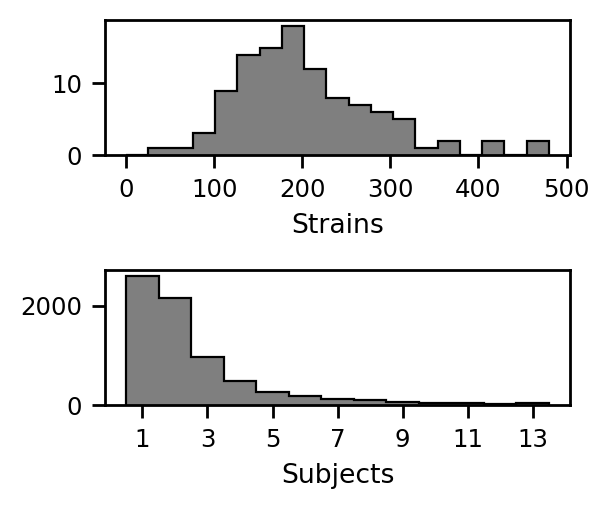

In [18]:
strain_by_sample = strain_present[species_strain_list]
strain_by_subject = (
    strain_by_sample.groupby(meta_all.subject_id).any().loc[:, strain_by_sample.any()]
)  # Exclude undetected strains.

total_strains_per_subject = strain_by_subject.sum(1)
total_subjects_per_strain = strain_by_subject.sum(0)
total_subjects_per_common_strain = total_subjects_per_strain[strain_by_sample.sum() > 1]

print("total_strains_per_sample", strain_by_sample.sum(1).quantile([0.25, 0.5, 0.75]))
print(
    "total_strains_per_subject", total_strains_per_subject.quantile([0.25, 0.5, 0.75])
)
print("num common strains", len(total_subjects_per_common_strain))
print(
    "total_subjects_per_strain",
    (total_subjects_per_strain == 0).mean(),
    (total_subjects_per_strain == 1).mean(),
    (total_subjects_per_strain >= 3).mean(),
)
print(
    "total_subjects_per_common_strain",
    (total_subjects_per_common_strain == 0).mean(),
    (total_subjects_per_common_strain <= 1).mean(),
    (total_subjects_per_common_strain <= 2).mean(),
)


fig, axs = plt.subplots(2, figsize=(3.0, 2.5), gridspec_kw=dict(hspace=0.85))
ax = axs[0]
bins = np.linspace(0, total_strains_per_subject.max(), num=20)
ax.hist(total_strains_per_subject, bins=bins, density=False, color="k", histtype="step")
ax.hist(total_strains_per_subject, bins=bins, density=False, color="k", alpha=0.5)
# ax.set_ylabel('Subjects')
ax.set_xlabel("Strains")

# fig.savefig('fig/spgc_strains_per_subject.svg', bbox_inches='tight')

# fig, ax = plt.subplots(figsize=(2, 1))
ax = axs[1]
bins = np.arange(1, 15)
ax.hist(
    total_subjects_per_common_strain,
    bins=bins,
    density=False,
    color="k",
    histtype="step",
    align="left",
)
ax.hist(
    total_subjects_per_common_strain,
    bins=bins,
    density=False,
    color="k",
    alpha=0.5,
    align="left",
)
ax.set_xticks(np.arange(1, 14, step=2))
# ax.set_ylabel('Strains')
# axs[1].set_yticks([0])
ax.set_xlabel("Subjects")
fig.savefig('fig/fig3ab_strain_subject.pdf', bbox_inches='tight')

In [19]:
# Distribution of strains found in at least 2 samples:
d0 = strain_by_subject.loc[:, (strain_by_sample.sum() >= 2)]
d1 = d0.sum()

(d1 == 0).mean(), (d1 == 1).mean(), (d1 >= 3).mean()

(0.0, 0.3634450834619161, 0.33426848085285454)

### Figure 3C

In [20]:
m, x = align_indexes(
    meta_all, strain_present[species_strain_list].drop(low_strain_samples)
)

shared_strains = pdist(x, metric=lambda x, y: (x & y).sum())
diff_subj = pdist(m[["subject_id"]], lambda x, y: (x != y).sum())

diff_subject: 0, mean: 36.736979166666664
diff_subject: 1, mean: 0.7385621380761684
diff_subject: 0, mean: 36.736979166666664
diff_subject: 1, mean: 0.7385621380761684


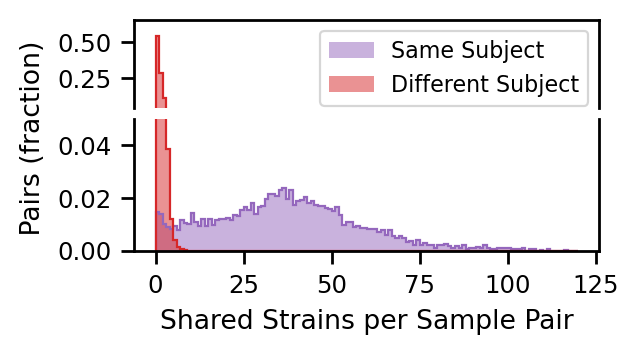

In [21]:
fig, axs = plt.subplots(
    2,
    figsize=(3, 1.5),
    gridspec_kw=dict(height_ratios=(0.4, 0.6), hspace=0.1),
    facecolor="none",
)

# bins = list(np.arange(0, 10)) + list(np.linspace(10, shared_strains.max(), num=10))
bins = np.arange(0, shared_strains.max())
for ax in axs:
    for _diff_subj, label, c in zip(
        [0, 1], ["Same Subject", "Different Subject"], ["tab:purple", "tab:red"]
    ):
        ax.hist(
            shared_strains[diff_subj == _diff_subj],
            alpha=0.5,
            color=c,
            bins=bins,
            density=True,
            label=label,
        )
        ax.hist(
            shared_strains[diff_subj == _diff_subj],
            histtype="step",
            color=c,
            bins=bins,
            density=True,
            label="__nolegend__",
        )
        print(
            f"diff_subject: {_diff_subj}, mean:",
            shared_strains[diff_subj == _diff_subj].mean(),
        )
axs[0].set_ylim(bottom=0.5, top=0.62)
axs[1].set_ylim(top=0.31)
axs[1].set_xlabel("Shared Strains per Sample Pair")
axs[1].set_ylabel("           Pairs (fraction)")
axs[0].legend(fontsize=8)

axs[1].spines["top"].set_visible(False)
axs[0].spines["bottom"].set_visible(False)
axs[0].set_xticks([])

axs[0].set_yticks([0.25, 0.5])
axs[0].set_ylim(0.05, 0.65)
axs[1].set_ylim(0.0, 0.05)
axs[1].set_yticks([0.0, 0.02, 0.04])

aspect = "auto"
axs[0].set_aspect(aspect)
axs[1].set_aspect(aspect)

fig.savefig('fig/fig3c_strain_sharing.pdf', bbox_inches='tight')

In [22]:
import lib.stats

lib.stats.mannwhitneyu(
    "x", "y", data=pd.DataFrame(dict(x=diff_subj.astype(bool), y=shared_strains))
)

(0.017221263096207237, 0.0)

In [23]:
sp.stats.mannwhitneyu(
    shared_strains[diff_subj.astype(bool)], shared_strains[~diff_subj.astype(bool)]
)

MannwhitneyuResult(statistic=128070939.5, pvalue=0.0)

In [24]:
# Shared strains between
other_strain_list = idxwhere(strain_depth.columns.to_series().str.endswith("-1"))
x = (strain_depth.groupby(meta_all.subject_id).max() > 0.1).drop(
    columns=other_strain_list
)

shared_strains_between_subjects = pdist(x, metric=lambda x, y: (x & y).sum())

In [25]:
pd.Series(shared_strains[diff_subj.astype(bool)]).quantile(
    [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99]
)

0.01    0.0
0.05    0.0
0.10    0.0
0.25    0.0
0.50    0.0
0.75    1.0
0.90    2.0
0.95    3.0
0.99    4.0
dtype: float64